In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial import distance
import matplotlib.pyplot as plt
import shutil
import math

In [2]:
pd.options.mode.chained_assignment=None

In [3]:
myDir=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading'
myFile=r'cell_info_DHB_tracking_clean.csv'
myPathFiles=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\individual_cells_tracking'

## Read and clean confocal data table

In [4]:
myData=pd.read_csv(os.path.join(myDir,myFile))

In [5]:
# total number of cells
len(myData)

373

In [6]:
myData.dropna(how="all",inplace=True)
len(myData)

356

In [7]:
# get rid of cells without a tracking number
myData=myData.loc[~np.isnan(myData.dhb_tracking)]
print(len(myData))
myData=myData.loc[~np.isnan(myData.x)]
print(len(myData))

# change format of exp string
myData['exp']=[str(int(x)) for x in myData.dhb_tracking]

354
352


In [8]:
# count experiments
myExpList=[str(int(x)) for x in myData.dhb_tracking.unique() if ~np.isnan(x)]
len(myExpList)

15

In [ ]:
# this cell was used to rename original tracking files (as there was a mismatch between cell ids and directory names)
# now there is a mismatch between individual csv files names and metadata inside the files
'''

#19062516007 19070816010
#19062516012 19070816012

myPathRevising = r'Z:\CookLab\Liu\20190816_organizedData_MCM_loading\individual_cells_tracking_revised'

for filename in os.listdir(myPathRevising):
    
    exp = filename[0:10]
    ID = filename[11:]
    if '19070816010' in filename:
        exp = '19062516007'
    elif '19070816012' in filename:
        exp = '19062516012'
    
    changed = exp + ID
    
    src = f'{myPathRevising}\\{filename}'
    dst = f'{myPathRevising}\\{changed}'
    os.rename(src, dst)
    shutil.move(dst, myPathFiles)

'''

In [9]:
myDataExp=pd.DataFrame(columns=['exp','cell_conf_total','cell_conf_org','cell_conf_decon','cell_track_num','cells'])

# find unique experiments
for i,myExp in enumerate(myExpList):
    
    # choose files that belong to this experiment
    myFilesCells=[x for x in os.listdir(myPathFiles) if str(myExp) in x]
    
    myDataExp.loc[i,'exp']=myExp
    
    myDataExp.loc[i,'cell_conf_total']=np.sum(myData.dhb_tracking==int(myExp))
    myDataExp.loc[i,'cell_conf_decon']=np.sum(np.array([myData.dhb_tracking==int(myExp)]) & np.array(['ims' in x for x in myData.file]))
    myDataExp.loc[i,'cell_conf_org']=myDataExp.loc[i,'cell_conf_total']-myDataExp.loc[i,'cell_conf_decon']
    
    myDataExp.loc[i,'cell_track_num']=len(myFilesCells)/2
    
    myDataExp.loc[i,'cells']=myFilesCells

In [10]:
myDataExp

,exp,cell_conf_total,cell_conf_org,cell_conf_decon,cell_track_num,cells
0,19061916009,30,15,15,15,"[190619160090006_metaData.txt, 190619160090001..."
1,19061916020,14,9,5,13,"[190619160200004_trackData.txt, 19061916020001..."
2,19061916019,7,4,3,4,"[190619160190001_metaData.txt, 190619160190003..."
3,19061916021,6,4,2,4,"[190619160210000_trackData.txt, 19061916021000..."
4,19061916011,10,5,5,5,"[190619160110002_trackData.txt, 19061916011000..."
5,19042616001,34,20,14,18,"[190426160010006_metaData.txt, 190426160010014..."
6,19060416009,61,31,30,35,"[190604160090008_trackData.txt, 19060416009002..."
7,19060416014,30,17,13,15,"[190604160140011_trackData.txt, 19060416014001..."
8,19062516007,32,16,16,15,"[190625160070012_metaData.txt, 190625160070004..."
9,19062516012,18,9,9,7,"[190625160120003_metaData.txt, 190625160120006..."


In [11]:
# what kind of files were there
cellFiles=np.unique([x[:11] for x in os.listdir(myPathFiles)])
cellFiles

array(['19042616001', '19060416009', '19060416014', '19061916009',
       '19061916011', '19061916019', '19061916020', '19061916021',
       '19062516007', '19062516012', '19062516017', '19070816010',
       '19070816015', '19070816016', '19070816017'], dtype='<U11')

In [12]:
len(cellFiles)

15

In [13]:
print(f'total number of cells (confocal): {np.sum(myDataExp.cell_conf_total)}')
print(f'total number of org cells: {np.sum(myDataExp.cell_conf_org)}')
print(f'total number of deconvolved cells: {np.sum(myDataExp.cell_conf_decon)}')

total number of cells (confocal): 352
total number of org cells: 186
total number of deconvolved cells: 166


Add information about deconvolution

In [14]:
myData.loc[:,'decon']=['ims' in x for x in myData.file]

## Read in tracking DHB measurements and match with confocal data

In [15]:
# read info from csv files
myList=[]

for myExp in myExpList:
    
    print(myExp)
    
    myCells=pd.DataFrame(columns=['exp','cell_id','track_length','x','y'])
    
    # choose only track data
    myFiles=[x for x in myDataExp.loc[myDataExp.exp==myExp,'cells'].values.tolist()[0] if 'trackData' in x]
    
    for i,myFile in enumerate(myFiles):
        
        myCell=pd.read_csv(os.path.join(myPathFiles,myFile),sep='\t')
        
        trackLength=np.sum(myCell.XM!=0)
        
        myCells.loc[i,'exp']=myExp
        myCells.loc[i,'cell_id']=int(myFile[11:15])
        myCells.loc[i,'track_length']=trackLength
        myCells.loc[i,'x']=myCell.XM.values.tolist()[-1]
        myCells.loc[i,'y']=myCell.YM.values.tolist()[-1]
        
    myList.append(myCells)

19061916009
19061916020
19061916019
19061916021
19061916011
19042616001
19060416009
19060416014
19062516007
19062516012
19062516017
19070816010
19070816015
19070816016
19070816017


In [16]:
myCells=pd.concat(myList,ignore_index=True)
myCells.head()

,exp,cell_id,track_length,x,y
0,19061916009,1,5,159.5,902
1,19061916009,4,73,949,190.5
2,19061916009,5,118,175,322.5
3,19061916009,13,48,378.5,377.5
4,19061916009,0,5,173.5,959.5


In [17]:
len(myCells)

186

In [18]:
for i,myCell in myData.iterrows():
    
    myTrackingData=myCells.loc[myCells.exp==myCell.exp]

    myTrackingData['dist']=np.sqrt(((np.array(myTrackingData.x)-myCell.x)**2+(np.array(myTrackingData.y)-myCell.y)**2).astype(float))

    try:
        myWin=myTrackingData.loc[np.argmin(myTrackingData.dist)]
        myData.loc[i,'track_cell_id']=myWin.cell_id
        myData.loc[i,'dist']=myWin.dist
        myData.loc[i,'x_track']=myWin.x
        myData.loc[i,'y_track']=myWin.y
        myData.loc[i,'track_length']=myWin.track_length
    except:
        myData.loc[i,'track_cell_id']=np.NaN

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [19]:
myData.tail()

,file,original cell name,Amy_mod,movie,x,y,ab1 (heterochromatin),ab1 ch,ab2 (MCM),ab2 ch,...,cell id for tracking,comment,dhb_tracking,exp,decon,track_cell_id,dist,x_track,y_track,track_length
368,201907016_cellde-13.ciz.ims,17-CO-M1L-63X,0,19-07-08 pcna dhbxy17,414.0,892.0,HP1B,1.0,MCM3,2.0,...,6.0,NaN,1.907082e+10,19070816017,True,6.0,4.527693,413.5,887.5,70.0
369,201907016_cellde-15.ciz.ims,17-CO-M2-63X,0,19-07-08 pcna dhbxy17,840.0,672.0,HP1B,1.0,MCM3,2.0,...,8.0,NaN,1.907082e+10,19070816017,True,8.0,6.964194,837.5,665.5,41.0
370,201907016_cellde-16.ciz.ims,17-CO-M3-63X,0,19-07-08 pcna dhbxy17,750.0,338.0,HP1B,1.0,MCM3,2.0,...,9.0,NaN,1.907082e+10,19070816017,True,9.0,5.000000,746.0,335.0,47.0
371,201907016_cellde-17.ciz.ims,17-CO-M4-63X,0,19-07-08 pcna dhbxy17,382.0,658.0,HP1B,1.0,MCM3,2.0,...,10.0,NaN,1.907082e+10,19070816017,True,10.0,0.500000,382.0,657.5,65.0
372,201907016_cellde-18.ciz.ims,17-CO-G2-63X,0,19-07-08 pcna dhbxy17,778.0,810.0,HP1B,1.0,MCM3,2.0,...,18.0,NaN,1.907082e+10,19070816017,True,18.0,1.802776,777.0,808.5,166.0


In [20]:
# calculate how many times there is a match
print(f'Liu tracking found {np.sum(~np.isnan(myData["cell id for tracking"]))}')
print(f'match {np.sum(myData["cell id for tracking"]==myData.track_cell_id)}')

Liu tracking found 230
match 221


<IPython.core.display.Javascript object>


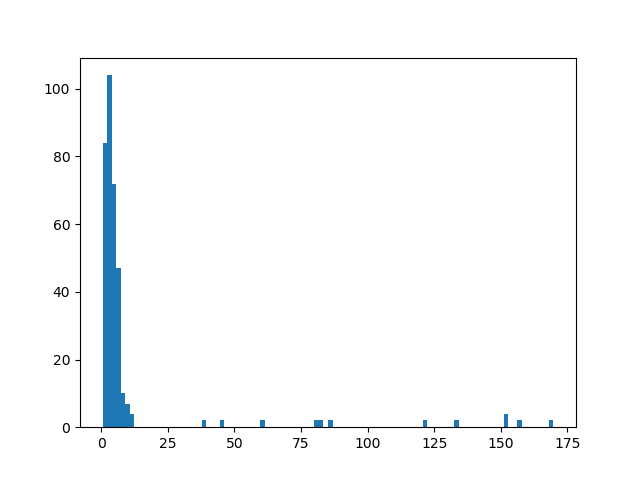

In [21]:
%matplotlib notebook
myHistogram=plt.hist(myData.dist,bins=100)

Here I make an arbitrary decision to keep only cells that match in position (distance below 20px).

In [22]:
myData_sel=myData.loc[myData.dist<20]
print(len(myData_sel))

328


## Add pathways to tiff files

In [23]:
myTiffDirList=[os.path.join(myDir,'DATA',x,'data_tiff') for x in os.listdir(os.path.join(myDir,'DATA'))]

#possible changes in file format
extList=['.tif','.tiff','.czi','.lsm','.ims','.ciz']

for myTiffDir in myTiffDirList:
    
    # list all the tiffs inside
    myTiffList=[x for x in os.listdir(myTiffDir) if 'tif' in x]
    
    for myTiff in myTiffList:
        
        for fileExt in extList:
        
            testName=myTiff.replace('.tif',fileExt)
            
            if (np.sum(myData_sel.file==testName)>0):
                
                break
                    
        myData_sel.loc[myData_sel.file==testName,'path']=os.path.join(myTiffDir,myTiff)
            

In [71]:
myTiffDir

'S:\\CookLab\\Liu\\20190816_organizedData_MCM_loading\\DATA\\20190506-MSL decon rename\\data_tiff'

## Remove entries that don't have data present

In [27]:
# test that all paths were found properly
# x==x gives false when x is None

print(f'all paths found: {np.sum([x==x for x in myData_sel.path])==len(myData_sel)}')
print(f'missing paths: {len(myData_sel) - np.sum([x==x for x in myData_sel.path])}/{len(myData_sel)}')
print(myData_sel.loc[myData_sel.path!=myData_sel.path,'file'])

all paths found: False
missing paths: 6/328
54     20190625_cellde-19.czi.ims
61     20190625_cellde-28.czi.ims
152    20190607_cellde-13.ciz.ims
239    20190701_cellde-01.ciz.ims
314         201907016_cell-11.ciz
317         201907016_cell-14.ciz
Name: file, dtype: object


In [28]:
print(f'remaining entries: {len(myData_sel)}')

remaining entries: 328


In [29]:
myData_sel.drop(myData_sel.index[myData_sel.path!=myData_sel.path],inplace=True)

In [30]:
print(f'remaining entries: {len(myData_sel)}')

remaining entries: 322


## Keep only cells that have org and deconvolved data

In [31]:
mD_g=myData_sel.groupby(['exp', 'track_cell_id'], as_index=False).count()


for i,myCell in myData_sel.iterrows():
    
    myExp=myCell.exp
    myID=myCell.track_cell_id
    
    paired=mD_g.loc[np.array(mD_g.exp==myExp) & np.array(mD_g.track_cell_id==myID),'file'].tolist()[0]
    
    myData_sel.loc[i,'paired']=(paired==2)

In [32]:
print(f'total number of both org and decon: {len(myData_sel)/2}')
print(f'number of cells with org, decon and matched tracking: {np.sum(myData_sel.paired)/2}')
print(f'number of cells to drop: {len(myData_sel.index[myData_sel.paired==False])}')

total number of both org and decon: 161.0
number of cells with org, decon and matched tracking: 154.0
number of cells to drop: 14


In [33]:
myData_sel.drop(myData_sel.index[myData_sel.paired==False],inplace=True)

In [34]:
print(f'remaining cells: {len(myData_sel)/2}')

remaining cells: 154.0


In [35]:
myData_sel.to_csv(os.path.join(myDir,'sel_cells_v1.csv'))

## Find matching DHB data

In [36]:
def openingFiles (tracking):
    
    # function to load data from the csv file into a data frame
    # input: part of the pathway specifying csv file
    # output: pandas data frame
    
    trackingDir=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\DHB_trackingData'
    
    if tracking is None:
        return None
    else:
        trackingFile =f'{trackingDir}\\{tracking}_DHB_.csv'
    
    return pd.read_csv(trackingFile)

In [37]:
np.sum(myData_sel.dhb_tracking==None)

0

Read information about DHB from the tracking files.

In [38]:
myData_sel['DHB_nucleus'] = 'mean'
myData_sel['DHB_cyto'] = 'mean ring'
myData_sel['DHB_ratio'] = 'ratio'

for i, a_row in myData_sel.iterrows():

    cell_id = int(a_row.track_cell_id)
    tracking = int(a_row.dhb_tracking)

    trackingData = openingFiles(tracking)

    if trackingData is None:
        print('yes')
        myData_sel.at[i, 'DHB_nucleus'] = None
        myData_sel.at[i, 'DHB_cyto'] = None
        myData_sel.at[i, 'DHB_ratio'] = None
        
    else:
        
        tracked_mean = trackingData.loc[trackingData['Cell ID #'] == cell_id, 'Mean']
        tracked_meanRing = trackingData.loc[trackingData['Cell ID #'] == cell_id, 'Mean ring']
        ratio = tracked_meanRing / tracked_mean

        tracked_mean = tracked_mean.tolist()
        tracked_meanRing = tracked_meanRing.tolist()
        ratio = ratio.tolist()

        myData_sel.at[i, 'DHB_nucleus'] = tracked_mean
        myData_sel.at[i, 'DHB_cyto'] = tracked_meanRing
        myData_sel.at[i, 'DHB_ratio'] = ratio
        
        myData_sel.at[i, 'DHB_len'] = len(ratio)

In [39]:
len(myData_sel)

308

## Drop cells without DHB measurement

In [40]:
myData_sel.drop(myData_sel.index[myData_sel.DHB_len==0],inplace=True)
print(f'number of cells remaining: {len(myData_sel)/2}')

number of cells remaining: 152.0


## Check physical age match

Compare measurement with the age specified by Liu:

1 is true - that the ages match

-1 is false - that the ages do not match

0 is none - not enough information to identify

In [41]:
err=4

myData_sel['physical_age_cleaned'] = 0.0
for i, row in myData_sel.iterrows():
    
    if myData_sel.loc[i, 'physical age [min]'] == "NA":
        myData_sel.loc[i, 'physical_age_cleaned'] = None
    elif myData_sel.loc[i, 'physical age [min]'] == "telo":
        myData_sel.loc[i, 'physical_age_cleaned'] = 0
    else:
        myData_sel.loc[i, 'physical_age_cleaned'] = float(myData_sel.loc[i, 'physical age [min]'])
    
    if np.isnan(myData_sel.loc[i, 'physical_age_cleaned']):
         myData_sel.loc[i, 'physicalAgeMatch'] = 0
            #'track_length'
    elif ((myData_sel.loc[i, 'physical_age_cleaned'] / 10) >  (myData_sel.loc[i,'DHB_len']-err)
         and (myData_sel.loc[i, 'physical_age_cleaned'] / 10) <  (myData_sel.loc[i, 'DHB_len']+err)):
        myData_sel.loc[i, 'physicalAgeMatch'] = 1
    else:
        myData_sel.loc[i, 'physicalAgeMatch'] = -1

In [42]:
print(f'cells with matching age (+/- 40min) {np.sum(myData_sel.physicalAgeMatch==1)/2}')
print(f'cells with mismatch in age {np.sum(myData_sel.physicalAgeMatch==-1)/2}')
print(f'cells with no age specified by Liu {np.sum(myData_sel.physicalAgeMatch==0)/2}')

cells with matching age (+/- 40min) 125.0
cells with mismatch in age 11.0
cells with no age specified by Liu 16.0


In [43]:
myData_sel.loc[:,'time_mismatch']=myData_sel.physical_age_cleaned/10-myData_sel.track_length
myData_sel.sort_values(by='time_mismatch',inplace=True)

<IPython.core.display.Javascript object>


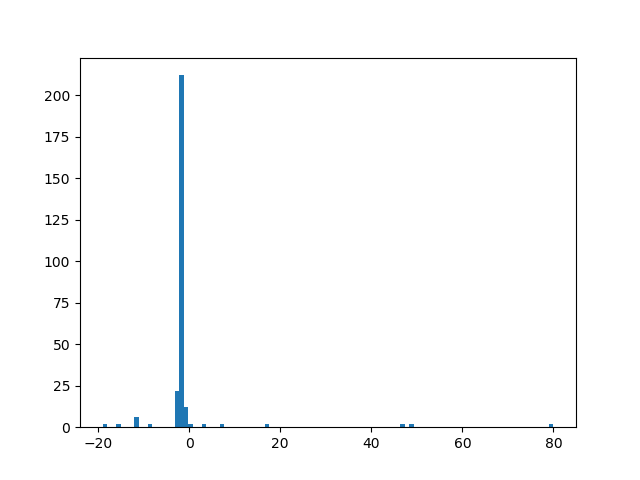

D:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [44]:
# look at the mismatch
%matplotlib notebook
h=plt.hist(myData_sel.time_mismatch,bins=100)

There is a mismatch between tracking files and measurements but it's not bigger than 1 region.

In [45]:
len(myData_sel)

304

In [46]:
np.sum(myData_sel.track_length==myData_sel.DHB_len)

290

In [47]:
myData_sel.loc[:,'track_vs_measure']=myData_sel.track_length-myData_sel.DHB_len

In [48]:
print(f'max diff: {np.max(myData_sel.track_length-myData_sel.DHB_len)}')
print(f'min diff: {np.min(myData_sel.track_length-myData_sel.DHB_len)}')

max diff: 0.0
min diff: -1.0


## Check molecular age match

In [49]:
myData_sel['molecularAgeMatch'] = True

for i, row in myData_sel.iterrows():
    
    ratio = myData_sel.at[i, 'DHB_ratio']
 
    expectedMole = round(myData_sel.at[i,'molecular age'],2)
    actualMole = round(ratio[len(ratio) - 1], 2)

    if expectedMole == actualMole:
        myData_sel.at[i, 'molecularAgeMatch'] = True
    else:
        myData_sel.at[i, 'molecularAgeMatch'] = False
        
    myData_sel.at[i, 'molecularAge_mismatch']=(expectedMole-actualMole)
    myData_sel.at[i, 'molecularAge_ratio']=actualMole

In [50]:
np.sum(myData_sel.molecularAgeMatch)

284

<IPython.core.display.Javascript object>


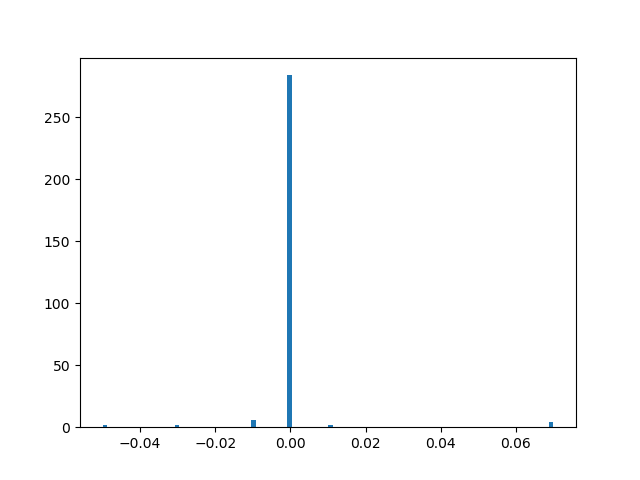

In [51]:
# look at the mismatch
%matplotlib notebook
h=plt.hist(myData_sel.molecularAge_mismatch,bins=100)

## Drop cells that don't match by both physical and molecular age

In [52]:
print(f'cells not matching by physical age: {np.sum(np.array(myData_sel.physicalAgeMatch==-1))/2}')

cells not matching by physical age: 11.0


In [53]:
print(f'cells not matching by molecular age: {np.sum(np.abs(np.array(myData_sel.molecularAge_mismatch))>0.005)/2}')

cells not matching by molecular age: 8.0


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [54]:
myData_sel.drop(myData_sel.index[(np.abs(np.array(myData_sel.molecularAge_mismatch))>0.005) & 
                                 (np.array(myData_sel.physicalAgeMatch==-1))],inplace=True)
print(f'number of cells remaining: {len(myData_sel)/2}')

number of cells remaining: 151.0


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [55]:
myData_sel.to_csv(os.path.join(myDir,'sel_cells_v1.csv'))

## Clean categories in columns

Check what kind of categories appear.

In [56]:
set(myData_sel.category)

{' late G1',
 'G2',
 'G2 ',
 'Late G1',
 'S phase',
 'close late G1',
 'close middle G1',
 'early G1',
 'early S',
 'earlyG1',
 'late G1',
 'middle G1',
 'middle G3',
 'midle G1',
 nan}

Check how many cells without the category specified.

In [57]:
np.sum([x!=x for x in myData_sel.category])

2

Drop cells without a category.

In [58]:
myData_sel.drop(myData_sel.index[[x!=x for x in myData_sel.category]],inplace=True)
print(f'number of cells remaining: {len(myData_sel)/2}')

number of cells remaining: 150.0


In [59]:
newCategory=myData_sel.category
newCategory=[x.replace(' ','') for x in newCategory]
newCategory=[x.replace('3','1') for x in newCategory]
newCategory=[x.replace('Late','late') for x in newCategory]
newCategory=[x.replace('midle','middle') for x in newCategory]
newCategory=[x.replace('close','') for x in newCategory]
newCategory=[x.replace('Sphase','S') for x in newCategory]
newCategory=[x.replace('earlyS','S') for x in newCategory]

In [60]:
set(newCategory)

{'G2', 'S', 'earlyG1', 'lateG1', 'middleG1'}

In [61]:
myData_sel.category=newCategory

In [62]:
set(myData_sel.category)

{'G2', 'S', 'earlyG1', 'lateG1', 'middleG1'}

In [70]:
myData_sel.groupby('category').count()

,file,original cell name,Amy_mod,movie,x,y,ab1 (heterochromatin),ab1 ch,ab2 (MCM),ab2 ch,...,DHB_cyto,DHB_ratio,DHB_len,physical_age_cleaned,physicalAgeMatch,time_mismatch,track_vs_measure,molecularAgeMatch,molecularAge_mismatch,molecularAge_ratio
category,,,,,,,,,,,,,,,,,,,,,
G2,26,26,26,26,26,26,26,26,26,26,...,26,26,26,20,26,20,26,26,24,26
S,12,12,12,12,12,12,12,12,12,12,...,12,12,12,6,12,6,12,12,12,12
earlyG1,150,150,150,150,150,150,150,150,150,150,...,150,150,150,150,150,150,150,150,150,150
lateG1,46,46,46,46,46,46,46,46,46,46,...,46,46,46,30,46,30,46,46,46,46
middleG1,66,66,66,66,66,66,66,66,66,66,...,66,66,66,62,66,62,66,66,66,66


In [65]:
myData_sel.sort_index(axis=0,inplace=True)
myData_sel.to_csv(os.path.join(myDir,'sel_cells_v1.csv'))